In [ ]:
!git clone https://github.com/cloner174/mr.DGA.git

In [ ]:
%cd mr.DGA

/content/mr.DGA


In [ ]:
#faces_ZIP_file_path_images -> 'data/output/pic/Faces-from-3.6.1.zip'
#faces_ZIP_file_path_seperated_images -> 'data/output/pic/seperated-Faces-from-3.6.1.zip'

In [ ]:
# Do Unzip jobs for
#                       faces_ZIP_file_path_images
#                       faces_ZIP_file_path_seperated_images

In [ ]:
!unzip 'data/output/pic/Faces-from-3.6.1.zip'
!unzip 'data/output/pic/seperated-Faces-from-3.6.1.zip'

In [ ]:
#path to main working files:

In [1]:
faces_img_path = 'data/output/pic/Faces-from-3.6.1'
faces_seperated_img_path_root = 'data/output/pic/seperated-Faces-from-3.6.1'
emo_map_guide_path = 'data/output/csv/images_emo_map.csv'
valid_data_path = 'data/output/csv/Data-Valid-from-3.6.1.csv.zip'

In [3]:
%pip install mediapipe dlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 114.5 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

In [ ]:
%pip install jax==0.4.28

In [2]:
import os
import cv2
import dlib
import time
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import mediapipe as mp
from main import Stats
from main import Utilities
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
#from google.colab.patches import cv2_imshow

ModuleNotFoundError: No module named 'dlib'

In [4]:
name_of_imgs = os.listdir(faces_img_path)
print(len(name_of_imgs), name_of_imgs[:6])

8707 ['face_7059.jpg', 'face_26452.jpg', 'face_31551.jpg', 'face_1481.jpg', 'face_20543.jpg', 'face_11470.jpg']


In [5]:
def simple_img_show(path_to_root_img_directory,
                    are_you_use_this_func_in_colab = False,
                    number_of_images_to_show = 5) :
    import random
    use_colab = are_you_use_this_func_in_colab
    name_of_images = os.listdir(path_to_root_img_directory)
    i_lim = 0
    random.shuffle(name_of_images)
    for name_of_image in name_of_images :
        if i_lim == number_of_images_to_show :
            break
        path_to_this_image = os.path.join(path_to_root_img_directory, name_of_image)
        image = cv2.imread(path_to_this_image)
        if use_colab:
            from google.colab.patches import cv2_imshow
            cv2_imshow(image)
        else:
            cv2.imshow('Image', image)
        i_lim += 1

In [ ]:
%pip install jax==0.4.28

In [ ]:
simple_img_show(faces_img_path, number_of_images_to_show = 3, are_you_use_this_func_in_colab= True)

In [ ]:
for i in range(7):#emotions label from 0 to 6 :
    temp_path = os.path.join(faces_seperated_img_path_root, str(i))
    print(f'Label{i}')
    simple_img_show(temp_path, are_you_use_this_func_in_colab=True)

In [25]:
# Loading Valid Data:

In [7]:
data = pd.read_csv(valid_data_path, compression='zip')
emo_map_guide = pd.read_csv(emo_map_guide_path, index_col = 4)
print('Data Valid shape: \n' ,data.shape,'\n')
print('Emotion Map-Guide shape: \n' ,emo_map_guide.shape,'\n')
time.sleep(2)
print('Data valid type of pixels: \n' ,type(data[' pixels'][0]),'\n')
time.sleep(2)
print('Data valid head: \n' ,data.head(3),'\n')
time.sleep(3)
print('Emotion Map-Guide head: \n' , emo_map_guide.head(3), '\n')
time.sleep(1)

Data Valid shape: 
 (8707, 3) 

Emotion Map-Guide shape: 
 (8707, 4) 

Data valid type of pixels: 
 <class 'str'> 

Data valid head: 
    Unnamed: 0  emotion                                             pixels
0        7059        3  30 26 26 26 26 26 25 24 25 26 26 26 26 27 29 2...
1       26452        5  0 0 0 4 26 29 23 40 100 105 103 103 103 105 11...
2       31551        3  31 30 31 33 41 47 61 74 79 59 59 112 144 134 1... 

Emotion Map-Guide head: 
        Unnamed: 0            name  \
iloc                                
7059            0   face_7059.jpg   
26452           1  face_26452.jpg   
31551           2  face_31551.jpg   

                                                  path  emotion  
iloc                                                             
7059    data/output/pic/Faces-from-3.6.1/face_7059.jpg        3  
26452  data/output/pic/Faces-from-3.6.1/face_26452.jpg        5  
31551  data/output/pic/Faces-from-3.6.1/face_31551.jpg        3   



In [8]:
data = data.set_axis(['indx', 'emotion', 'pixels'], axis = 1)
print('Data Valid head after renaming cols: \n\n' ,data.head(2),'\n')

Data Valid head after renaming cols: 

     indx  emotion                                             pixels
0   7059        3  30 26 26 26 26 26 25 24 25 26 26 26 26 27 29 2...
1  26452        5  0 0 0 4 26 29 23 40 100 105 103 103 103 105 11... 



In [9]:
def strings_with_number_inside( data,
                                    index_iloc = None,
                                    label_iloc = None,
                                    column_range_starts : int = 0,
                                    column_range_ends : int = None,
                                    seperator = None):
        start = column_range_starts
        end = int( data.shape[1] ) if column_range_ends is None else column_range_ends
        new_data = []
        try :
            for i in range( data.shape[0] ) :
                temp_new_data = {}
                for j in range( start, end ) :
                    cells_real_values = np.array(data.iloc[i, j].split(sep = seperator), dtype='uint8')
                    if index_iloc is not None:
                      temp_new_data['index'] = data.iloc[i, index_iloc]
                    else:
                      temp_new_data['index'] = i
                    temp_new_data['pixels'] = cells_real_values
                    if label_iloc:
                      temp_new_data['emotin'] = data.iloc[i, label_iloc]
                new_data.append(temp_new_data)

            return new_data
        except:
            if isinstance( data , np.array ) :
                pass
            else:
                raise TypeError( " data just could be  PandasDataFrame  or  NumpyArray  ! ")

In [10]:
data.head()

,indx,emotion,pixels
0,7059,3,30 26 26 26 26 26 25 24 25 26 26 26 26 27 29 2...
1,26452,5,0 0 0 4 26 29 23 40 100 105 103 103 103 105 11...
2,31551,3,31 30 31 33 41 47 61 74 79 59 59 112 144 134 1...
3,1481,4,32 29 27 30 32 33 40 49 65 86 48 14 8 6 10 17 ...
4,20543,3,60 29 24 40 38 36 29 32 28 25 31 20 23 25 23 2...


In [11]:
data_fixed = strings_with_number_inside(data, index_iloc = 0, label_iloc = 1, column_range_starts = 2)

In [12]:
data_fixed = pd.DataFrame(data_fixed)

In [13]:
print('Data Valid head after fixing the type of each pixel rows: \n\n' ,data_fixed.head(),'\n')
time.sleep(2)
print('\n', 'We are going to call the fixed-Data-Valid , -> data_fixed <- since now on : \n\n' ,'\n')

Data Valid head after fixing the type of each pixel rows: 

    index                                             pixels  emotin
0   7059  [30, 26, 26, 26, 26, 26, 25, 24, 25, 26, 26, 2...       3
1  26452  [0, 0, 0, 4, 26, 29, 23, 40, 100, 105, 103, 10...       5
2  31551  [31, 30, 31, 33, 41, 47, 61, 74, 79, 59, 59, 1...       3
3   1481  [32, 29, 27, 30, 32, 33, 40, 49, 65, 86, 48, 1...       4
4  20543  [60, 29, 24, 40, 38, 36, 29, 32, 28, 25, 31, 2...       3 


 We are going to call the fixed-Data-Valid , -> data_fixed <- since now on : 

 



In [14]:
#Some fixing of data to be ready
data_fixed = data_fixed.set_index('index')
data_fixed.sort_index(inplace=True)
emo_map_guide.sort_index(inplace=True)
emo_map_guide.head(3),'\n', data_fixed.head(3)

(      Unnamed: 0        name                                         path  \
 iloc                                                                        
 0           1655  face_0.jpg  data/output/pic/Faces-from-3.6.1/face_0.jpg   
 4           7659  face_4.jpg  data/output/pic/Faces-from-3.6.1/face_4.jpg   
 5             56  face_5.jpg  data/output/pic/Faces-from-3.6.1/face_5.jpg   
 
       emotion  
 iloc           
 0           0  
 4           6  
 5           2  ,
 '\n',
                                                   pixels  emotin
 index                                                           
 0      [70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...       0
 4      [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...       6
 5      [55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...       2)

In [ ]:
# Adding additional information to our fixed_data

In [15]:
emo_map_guide.head()

,Unnamed: 0,name,path,emotion
iloc,,,,
0,1655,face_0.jpg,data/output/pic/Faces-from-3.6.1/face_0.jpg,0
4,7659,face_4.jpg,data/output/pic/Faces-from-3.6.1/face_4.jpg,6
5,56,face_5.jpg,data/output/pic/Faces-from-3.6.1/face_5.jpg,2
7,4237,face_7.jpg,data/output/pic/Faces-from-3.6.1/face_7.jpg,3
8,3564,face_8.jpg,data/output/pic/Faces-from-3.6.1/face_8.jpg,3


In [16]:
data_fixed['name'] = emo_map_guide['name']
data_fixed['path'] = emo_map_guide['path']
data_fixed['back_up_emotion'] = emo_map_guide['emotion']

In [17]:
data_fixed.head()

,pixels,emotin,name,path,back_up_emotion
index,,,,,
0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",0,face_0.jpg,data/output/pic/Faces-from-3.6.1/face_0.jpg,0
4,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",6,face_4.jpg,data/output/pic/Faces-from-3.6.1/face_4.jpg,6
5,"[55, 55, 55, 55, 55, 54, 60, 68, 54, 85, 151, ...",2,face_5.jpg,data/output/pic/Faces-from-3.6.1/face_5.jpg,2
7,"[77, 78, 79, 79, 78, 75, 60, 55, 47, 48, 58, 7...",3,face_7.jpg,data/output/pic/Faces-from-3.6.1/face_7.jpg,3
8,"[85, 84, 90, 121, 101, 102, 133, 153, 153, 169...",3,face_8.jpg,data/output/pic/Faces-from-3.6.1/face_8.jpg,3


In [18]:
unmatch_emotions_police = []

for any_ in data_fixed.index:
  if data_fixed.loc[any_, 'emotin'] != data_fixed.loc[any_, 'back_up_emotion']:
    unmatch_emotions_police.append(any_)
    warnings.warn(f" One or more NoN-Match Items founded in data// this time index number : {any_}")
  else:
    pass
if len(unmatch_emotions_police)==0:
  print(" Data was Seccessfuly Scaned and there is NO unmatch items. ")

 Data was Seccessfuly Scaned and there is NO unmatch items. 


In [19]:
# pre-trained face detection model for face area cropping
model = "models/face_detector_advance/res10_300x300_ssd_iter_140000.caffemodel"
config = "models/face_detector_advance/deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(config, model)

In [1]:
# Function to detect and crop faces in an image

def detect_and_crop_faces(image_array_input, image_size = (48,48), show_ = False, are_you_using_colab = True):
    
    image_array = np.array(image_array_input, dtype=np.uint8).reshape(image_size[0], image_size[1])
    image_rgb = np.stack((image_array,) * 3, axis=-1)
    # 300x300 size for the model
    blob = cv2.dnn.blobFromImage(image_rgb, 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # Pass the blob through the network and obtain the face detections
    net.setInput(blob)
    detections = net.forward()
    
    face = None
    for i in range(detections.shape[2]):
        
        confidence = detections[0, 0, i, 2]
        
        # filter out weak detections by the confidence greater than minimum
        if confidence > 0.5:
            # x, y coordinates of face
            box = detections[0, 0, i, 3:7] * np.array([image_array.shape[1], image_array.shape[0], image_array.shape[1], image_array.shape[0]])
            (startX, startY, endX, endY) = box.astype("int")
                
            # crop the face region from the image
            face = image_array[startY:endY, startX:endX]
    if face is not None and are_you_using_colab == True and show_ == True:
        cv2_imshow(face)
    elif face is not None and are_you_using_colab == False and show_ == True:
        print("sorry, face was there but we are just able to show you inside google colab.")
        time.sleep(1)
        print(" Try manually use cv2.imshow(SOME_STRING, VALUE_FROM_THIS_METHOD) function with the value returned from this method to see the result!")
    else:
        pass
    return face


In [22]:
# Insure the right value was pass to the function:
type(data_fixed['pixels'][0]), data_fixed['pixels'][0].shape

(numpy.ndarray, (2304,))

In [23]:
#reshaping image array to be teh correct size:
image_array = data_fixed['pixels'][0].reshape(48,48)
print(type(image_array), image_array.shape)

<class 'numpy.ndarray'> (48, 48)


In [24]:
# testing

cropped_face = detect_and_crop_faces(image_array, show_=True)

In [ ]:
# predictor path :
# frontal face detection object :

In [ ]:
predictor_path = "models/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(predictor_path)

detector = dlib.get_frontal_face_detector()

In [ ]:
def plot_delaunay(points, delaunay, ax):
    for simplex in delaunay.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')


def triangular_detection_of_facial_parts(id,
                                         image_array = None,
                                         image_path = None,
                                         show_fig = True,
                                         save_fig = False,
                                         save_path = 'data/output/pic/triangular_detection_of_facial_parts/'):
    if image_array is None and image_path is not None:
        img = Image.open(image_path)
        img = np.array(img)
    elif image_array is not None and image_path is None:
      img = image_array.reshape(48, 48)
    elif image_array is not None and image_path is not None:
      warnings.warn(" Both image_array and image_path are provided, ")
      warnings.warn(" Using Default Setup :  image_array ")
      warnings.warn(" if you see any error furtehr, try run this method with just the image_path and leave the image_array to be None !")
    else:
      raise AssertionError(" You must provide either image_array or image_path to this method could work!")
    ax = plt.gca()
    ax.imshow(img)
    detections = detector(img, 1)
    for k, d in enumerate(detections):
        shape = predictor(img, d)
        points = np.array([[p.x, p.y] for p in shape.parts()])
        ax.scatter(points[:, 0], points[:, 1], c='r', s=10)
        delaunay = Delaunay(points)
        plot_delaunay(points, delaunay, ax)
    plt.axis('off')
    if save_fig:
      path_to_save = os.path.join(save_path, f'image{id}.jpg')
      try:
        os.mkdir(save_path)
      except:
        pass
      plt.savefig(path_to_save)
    if show_fig:
      plt.show()
    else:
      return




In [ ]:

def plot_delaunay(points, delaunay, ax):
    for simplex in delaunay.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')


def get_delaunay_for_part(points, part_indices):
    part_points = points[part_indices]
    return Delaunay(part_points)


def detect_faces_and_triangulate_parts(image_path = None, image_array = None, return_detected_info = False):
    #img = Image.open(image_path)
    #img = np.array(img)
    img = image_array
    ax = plt.gca()
    ax.imshow(img)

    detections = detector(img, 1)
    for k, d in enumerate(detections):
        shape = predictor(img, d)
        points = np.array([[p.x, p.y] for p in shape.parts()])
        ax.scatter(points[:, 0], points[:, 1], c='r', s=10)

        #temp1 = np.arange(24, 36)
        eye_indices = np.arange(36, 48)
        lip_indices = np.arange(48, 68)
        #temp2 = np.arange(68, 80)

        #eye_delaunay = get_delaunay_for_part(points, temp1)
        #lip_delaunay = get_delaunay_for_part(points, temp2)
        eye_delaunay = get_delaunay_for_part(points, eye_indices)
        lip_delaunay = get_delaunay_for_part(points, lip_indices)


        plot_delaunay(points, eye_delaunay, ax)
        plot_delaunay(points, lip_delaunay, ax)

    plt.axis('off')
    plt.show()

#

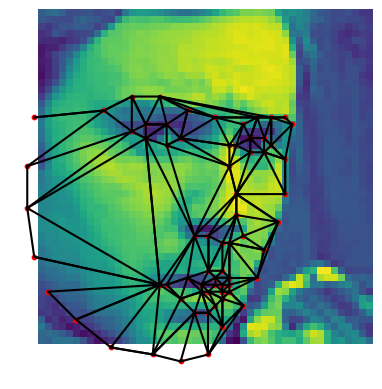

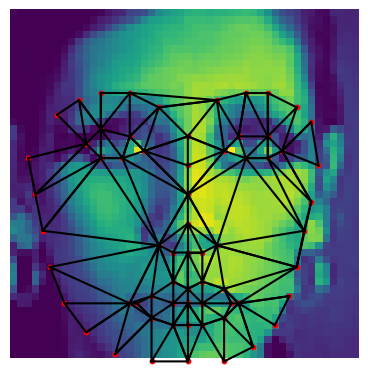

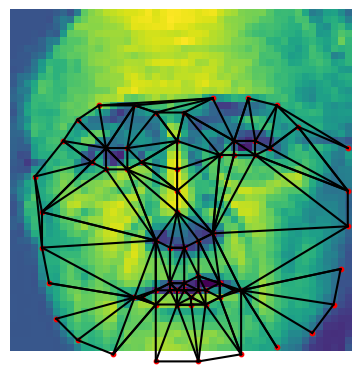

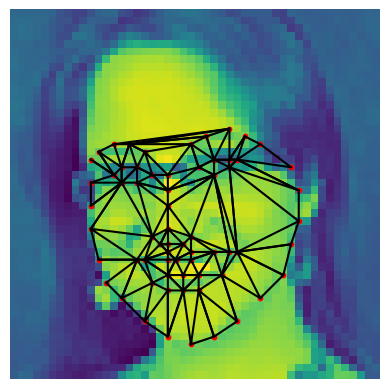

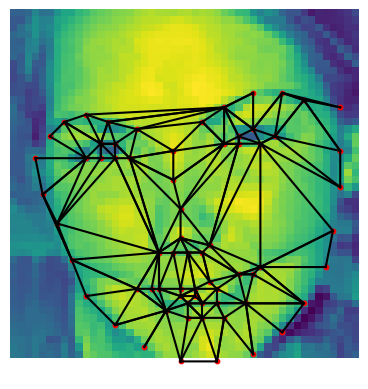

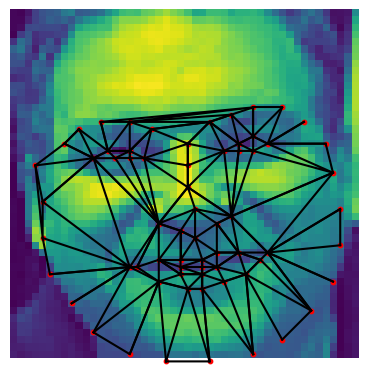

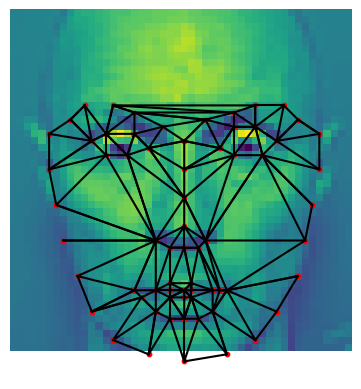

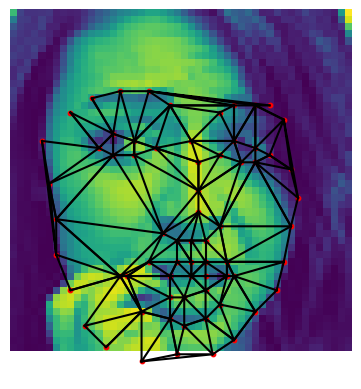

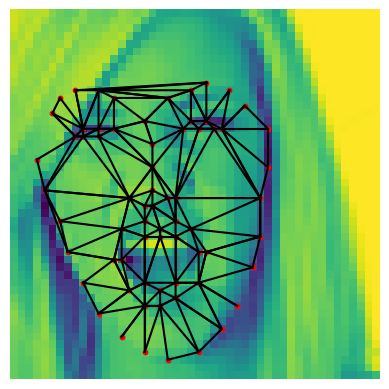

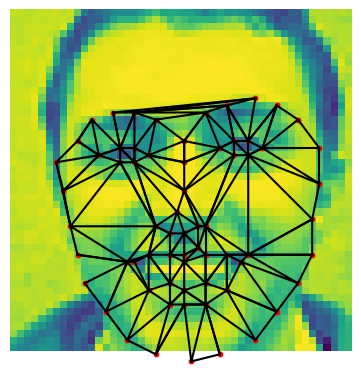

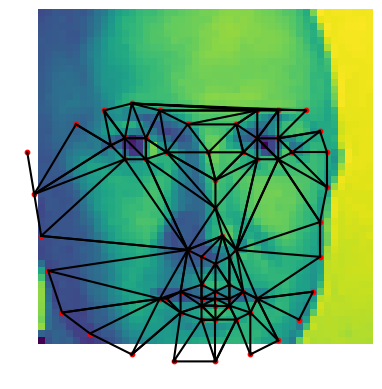

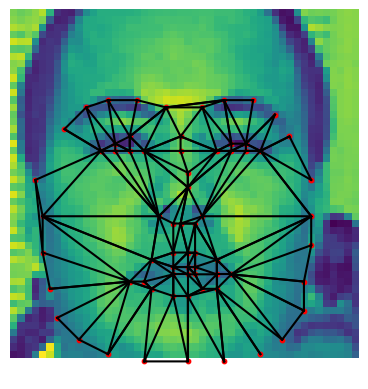

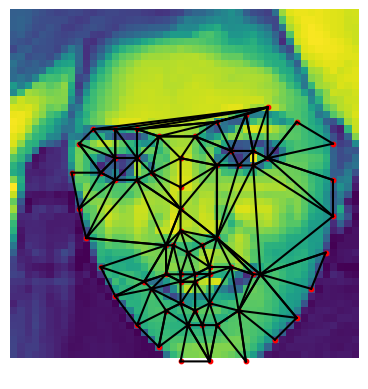

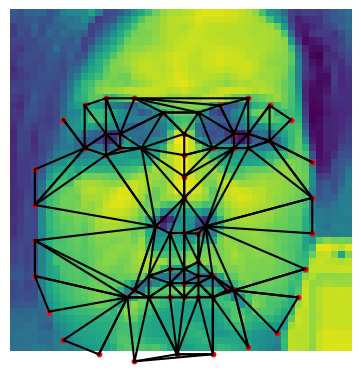

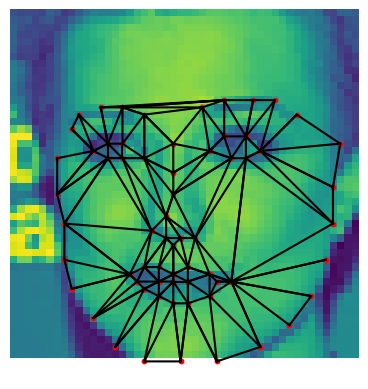

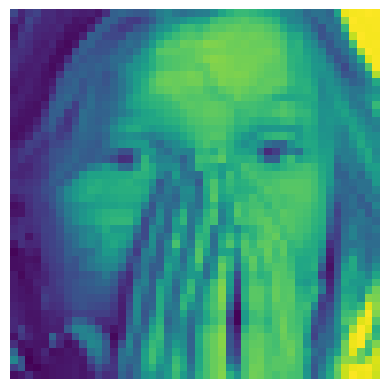

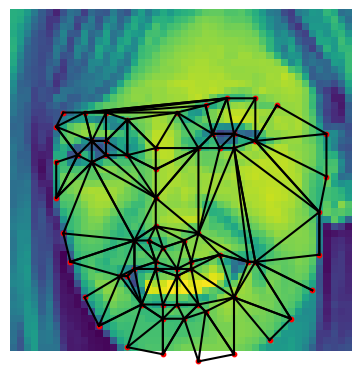

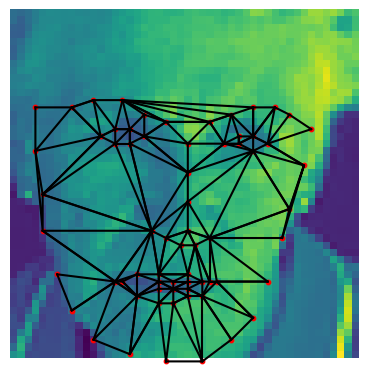

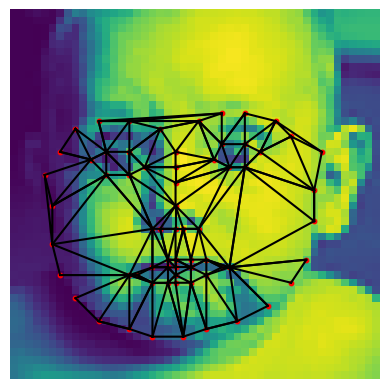

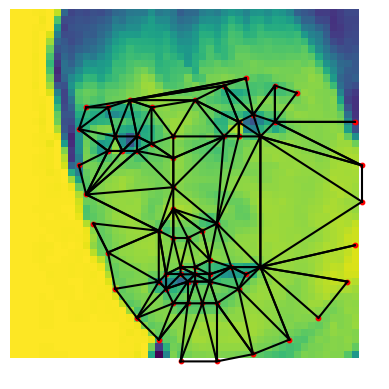

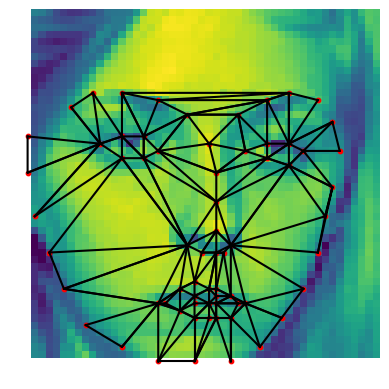

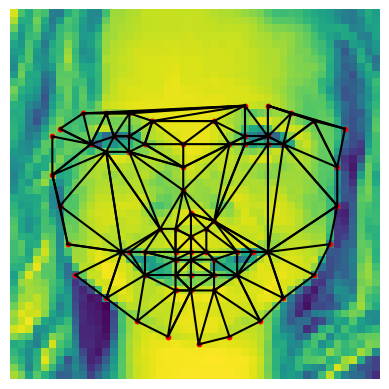

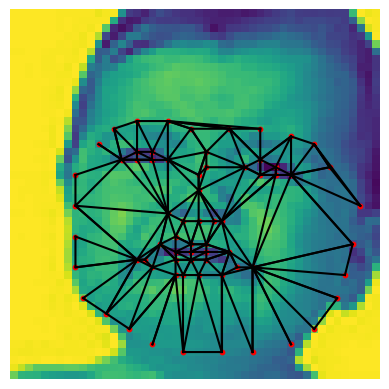

In [ ]:
for i in data_fixed.index:
  triangular_detection_of_facial_parts(image_array=data_fixed.loc[i, 'pixels'],id =i)

In [ ]:
for image_file in os.listdir(faces_img_path):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(faces_img_path, image_file)
        detect_faces_and_triangulate_parts(image_path)

In [ ]:
def draw_point(  point : tuple ,
                image,
                n = 1,
                m = 1,
                forward_backward = False,
                color = (0, 0, 255),
                radius = 0,
                thickness= -1 ,
                are_you_using_colab = True):

    (x, y) = point
    x, y = int(x * image.shape[1]), int(y * image.shape[0])
    for i in range(n):
        x = x - 1
        cv2.circle(image, (x, y), radius, color, thickness)
    for i in range(m):
        y = y + m     #y += 1
        cv2.circle(image, (x, y), radius, color, thickness)
    if not forward_backward:
        pass
    else:
        for _ in range(n):
            x = x + 1
            cv2.circle(image, (x, y), radius, color, thickness)
        for _ in range(m):
            y = y - m
            cv2.circle(image, (x, y), radius, color, thickness)
        if are_you_using_colab:
            cv2_imshow(image)
        else:
            cv2.imshow('Image with Point', image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [ ]:
def simple_draw_point(  point : tuple ,
                        image,
                        color = (0, 0, 255),
                        radius = 1,
                        thickness=-1 ,
                        are_you_using_colab = True):
    (x, y) = point
    x, y = int(x * image.shape[1]), int(y * image.shape[0])
    cv2.circle(image, (x, y), radius, color, thickness)
    if are_you_using_colab:
        cv2_imshow(image)
    else:
        cv2.imshow('Image with Point', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [ ]:
detector = dlib.get_frontal_face_detector()

def plot_delaunay(points, delaunay, ax):
    for simplex in delaunay.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')

def detect_faces_and_triangulate(image_path):
    img = Image.open(image_path)
    img = np.array(img)

    ax = plt.gca()
    ax.imshow(img)

    detections = detector(img, 1)
    for k, d in enumerate(detections):
        shape = predictor(img, d)
        points = np.array([[p.x, p.y] for p in shape.parts()])
        ax.scatter(points[:, 0], points[:, 1], c='r', s=10)
        delaunay = Delaunay(points)
        plot_delaunay(points, delaunay, ax)

    plt.axis('off')
    plt.show()




In [ ]:
for image_file in os.listdir(image_directory):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_directory, image_file)
        detect_faces_and_triangulate(image_path)

In [ ]:

def plot_delaunay(points, delaunay, ax):
    for simplex in delaunay.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')


def get_delaunay_for_part(points, part_indices):
    part_points = points[part_indices]
    return Delaunay(part_points)


def detect_faces_and_triangulate_parts(image_path, return_detected_info = False):
    img = Image.open(image_path)
    img = np.array(img)
    ax = plt.gca()
    ax.imshow(img)

    detections = detector(img, 1)
    for k, d in enumerate(detections):
        shape = predictor(img, d)
        points = np.array([[p.x, p.y] for p in shape.parts()])
        ax.scatter(points[:, 0], points[:, 1], c='r', s=10)

        temp1 = np.arange(24, 36)
        eye_indices = np.arange(36, 48)
        lip_indices = np.arange(48, 68)
        temp2 = np.arange(68, 80)

        eye_delaunay = get_delaunay_for_part(points, temp1)
        lip_delaunay = get_delaunay_for_part(points, temp2)
        #eye_delaunay = get_delaunay_for_part(points, eye_indices)
        #lip_delaunay = get_delaunay_for_part(points, lip_indices)


        plot_delaunay(points, eye_delaunay, ax)
        plot_delaunay(points, lip_delaunay, ax)

    plt.axis('off')
    plt.show()

#

In [ ]:
for image_file in os.listdir(image_directory):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_directory, image_file)
        detect_faces_and_triangulate_parts(image_path)